In [1]:
%matplotlib inline

import cv2
import numpy as np
import torchvision.transforms as T
from matplotlib import pyplot as plt

In [2]:
image_path = "/home/saad/Personal/Misc/Neon/image-colorization_d6a566/data/85.jpg"

img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

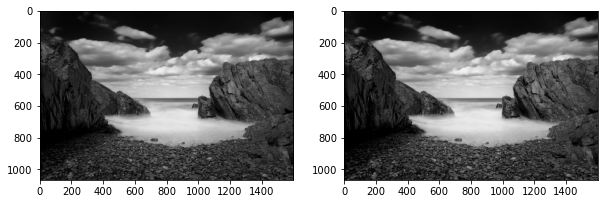

In [3]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
ax.imshow(gray, cmap='gray', vmin=0, vmax=255)
bx.imshow(img[:, :, :1], cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
print(gray.shape)
print(img.shape)

(1066, 1600)
(1066, 1600, 3)


In [9]:
new_img = np.vstack((gray[:, :, np.newaxis].transpose(2, 0, 1), img[:, :, 1:].transpose(2, 0, 1))).transpose(1, 2, 0)
new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

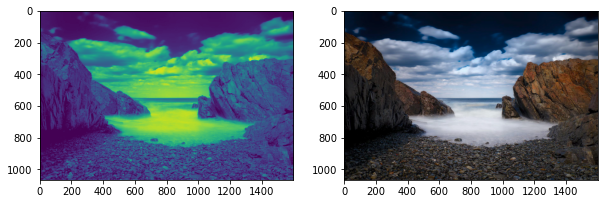

In [10]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
ax.imshow(gray, vmin=0, vmax=255)
bx.imshow(new_img, vmin=0, vmax=255)
plt.show()

In [3]:
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5), (0.5, 0.5))
])

In [4]:
img_tensor = normalize(new_img[:, :, 1:])

NameError: name 'new_img' is not defined

In [5]:
class UnNormalizeImage(object):

    def __init__(self, mean, std) -> None:
        self.mean = mean
        self.std = std

    def __call__(self, img):
        
        for tensor_c, mean_c, std_c in zip(img, self.mean, self.std):
            tensor_c.mul(std_c).add(mean_c)

        return img

In [6]:
print(T.ToTensor()(new_img[:, :, 1:]))
print(img_tensor)
print(T.Normalize((-1.0, -1.0), (2.0, 2.0))(img_tensor))

NameError: name 'new_img' is not defined

In [17]:
UnNormalizeImage((0.5, 0.5), (0.5, 0.5))(img_tensor)

tensor([[[-0.8353, -0.8353, -0.8353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.8353, -0.8353, -0.8353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.8353, -0.8353, -0.8353,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -0.9843,  ..., -0.9843, -0.8980, -0.9686],
         [-1.0000, -0.9216, -0.8745,  ..., -1.0000, -0.9843, -0.8510],
         [-1.0000, -0.9216, -0.8745,  ..., -0.7176, -0.7882, -0.7804]],

        [[-0.6314, -0.6314, -0.6314,  ..., -0.9529, -0.9529, -0.9529],
         [-0.6314, -0.6314, -0.6314,  ..., -0.9529, -0.9529, -0.9529],
         [-0.6314, -0.6314, -0.6314,  ..., -0.9529, -0.9529, -0.9529],
         ...,
         [-1.0000, -0.9686, -1.0000,  ..., -1.0000, -0.9373, -0.9843],
         [-0.9686, -0.9451, -0.9059,  ..., -1.0000, -1.0000, -0.8824],
         [-0.9686, -0.9451, -0.9059,  ..., -0.7176, -0.7882, -0.7882]]])

In [111]:
import numpy as np
import torch
import torchvision.transforms as T
from skimage.transform import resize
from skimage.color import rgb2lab, gray2rgb, lab2rgb

class NormalizeLab(object):
    
    def __init__(self) -> None:
        pass

    def __call__(self, image):

        assert len(image.shape) == 3

        if image.shape[-1] == 1:
            image = gray2rgb(image)

        lab = rgb2lab(image)

        lab[:, :, :1] /= 100.0
        lab[:, :, 1:] = (lab[:, :, 1:] + 128.0) / 256.0

        return lab

class UnnormalizeLab(object):

    def __init__(self) -> None:
        pass

    def __call__(self, L, ab):

        L = L.numpy()*100.0
        ab = (ab.numpy() * 255.0) - 127.0

        return L, ab

class ToTensor(object):

    def __init__(self) -> None:
        pass

    def __call__(self, image):

        assert image.shape == (256, 256, 3)

        image = torch.from_numpy(image.astype(np.float32).transpose(2, 0, 1))

        return image

class ResizeImage(object):

    def __init__(self, size=256) -> None:
        self.size = size

    def __call__(self, image):
        
        assert image.shape[-1] == 3

        image = resize(image, (self.size, self.size))

        return image
    
class DiscretizeImage(object):

    def __init__(self, bin_path="../priors/pts_in_hull.npy"):
        self._bin_centers = np.load(bin_path).T
    
    def __call__(self, image):

        assert len(image.shape) == 3

        lab = rgb2lab(image)
        L, ab = lab[:, :, :1], lab[:, :, 1:]
        
        distances = np.sqrt(((ab[:, :, np.newaxis, :]-self._bin_centers.T[np.newaxis, np.newaxis, :, :])**2).sum(axis=3))
        
        binned = np.argmin(distances, axis=2)
        
        return (lab[:, :, :1], binned)
    
class NormalizeLChannel(object):
    
    def __init__(self):
        pass
    
    def __call__(self, L_and_binned):
        L, binned = L_and_binned
        
        assert L.shape[-1] == 1
        
        L /= 100.0
        
        return L, binned
        
class GenerateABComponent(object):
    
    def __init__(self, bin_path="../priors/pts_in_hull.npy"):
        self._bin_centers = np.load(bin_path).T
        pass
    
    def __call__(self, tensor):
        
        ab_image = np.zeros((tensor.shape[0], tensor.shape[1], 2))
        
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                ab_image[i, j] = self._bin_centers[:, tensor[i, j]]
        
        return ab_image


class TensorizeBins(object):

    def __init__(self) -> None:
        pass

    def __call__(self, L_and_binned):
        
        L, binned = L_and_binned
        
        assert L.shape[-1] == 1
        
        print(torch.from_numpy(L.astype(np.float32)).shape)
        print(binned.shape)

        L_tensor = torch.from_numpy(L.astype(np.float32).transpose(2, 0, 1))
        binned_tensor = torch.nn.functional.one_hot(torch.from_numpy(binned), num_classes=313)

        return L_tensor, binned_tensor

In [46]:
from skimage import io

img_sk = io.imread(image_path)

In [84]:
discretize = DiscretizeImage()
new_img_l, new_img_bin = discretize(img_sk/255.0)

In [77]:
print(np.min(new_img), np.max(new_img))

0 312


In [78]:
abfier = GenerateABComponent()
ab_ = abfier(new_img_bin)
print(ab_.shape)
print(np.min(ab_), np.max(ab_))

(1066, 1600, 2)
-50.0 40.0


In [79]:
img_rgb = lab2rgb(np.dstack((new_img_l, ab_)))

In [43]:
transform = T.Compose([ResizeImage(),
          NormalizeLab(),
          ToTensor()
          ])

In [112]:
binned_transform = T.Compose([
    ResizeImage(),
    DiscretizeImage(),
    NormalizeLChannel(),
    TensorizeBins()
])

In [113]:
b_img_L, b_img_bins = binned_transform(img_sk/255.0)

torch.Size([256, 256, 1])
(256, 256)


In [116]:
print(torch.min(b_img_L), torch.max(b_img_L))
b_img_labels = np.argmax(b_img_bins, axis=2)
l_ = b_img_L.numpy().transpose(1, 2, 0)
ab_ = abfier(b_img_labels)
img_rgb = lab2rgb(np.dstack((l_*100.0, ab_)))

tensor(0.) tensor(0.9485)


In [44]:
tensor = transform(img/255.0)

In [45]:
print(tensor.shape)

torch.Size([3, 256, 256])


In [64]:
tensor = transform(img_sk/255.0)

In [65]:
L = tensor[:1, :, :]
ab = tensor[1:, :, :]

In [66]:
L_u, ab_u = UnnormalizeLab()(L, ab)

In [59]:
lab = rgb2lab(img_sk)

In [53]:
print(L_u.shape)
print(ab_u.shape)

(1, 256, 256)
(2, 256, 256)


In [67]:
new_img = np.vstack((L_u, ab_u)).transpose(1, 2, 0)

In [68]:
new_img = lab2rgb(lab)

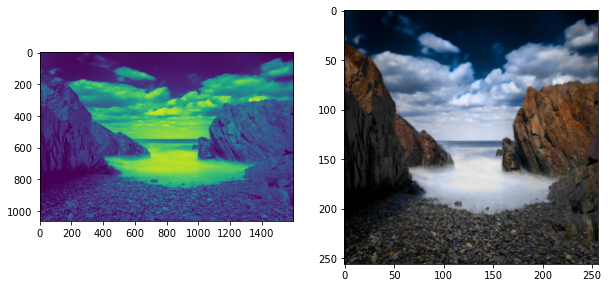

In [117]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
ax.imshow(gray, vmin=0, vmax=255)
bx.imshow(img_rgb, vmin=0, vmax=1.0)
plt.show()